# Demo a Single Simulation Run

In this notebook, we demonstrate a single run of our risk simulation:
- We show the logs of agent actions (e.g. liquidations, arbitrages, peg keeper updates).
- We show a timeseries view of the metrics we collect on agents and the crvusd contracts.
- We plot and analyze results

### Some current limitations
- We are only modeling a single LLAMMA. We are working to incorporate all LLAMMAs to consider hollistic systemic risk.
- We are not considering some key Curve pools yet. For example, we are not explicitly modeling the TriCrypto-ng pools that feed into LLAMMA's oracle.

In [44]:
import pandas as pd
import cProfile
import pstats

from src.logging import get_logger

logger = get_logger(__name__, "debug")

from src.sim.scenario import Scenario
from src.sim.processing import SingleSimProcessor
from src.metrics import DEFAULT_METRICS

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# Generate markets and prices
market_name = "wstETH"
scenario = Scenario("baseline", market_name)
scenario.prepare_for_run()
print(
    f"Running {scenario.num_steps} steps with frequency {scenario.pricepaths.config['freq']}."
)

[INFO][11:07:20][src.sim.scenario]-22561: Fetching sim_market from subgraph.


[INFO][11:07:33][src.utils.poolgraph]-22561: Found 20 valid trading cycles of length 3.


Running 168 steps with frequency 1h.


In [46]:
processor = SingleSimProcessor(scenario, DEFAULT_METRICS)
processor.initial_state

{'timestamp': Timestamp('2023-12-21 14:07:27'),
 'arbitrageur_profit': 0,
 'arbitrageur_volume': 0,
 'arbitrageur_count': 0,
 'liquidator_profit': 0.0,
 'liquidator_volume': 0,
 'liquidator_count': 0,
 'keeper_profit': 0.0,
 'keeper_volume': 0,
 'keeper_count': 0,
 'borrower_profit': 0.0,
 'borrower_volume': 0,
 'borrower_count': 0,
 'liquidityprovider_profit': 0.0,
 'liquidityprovider_volume': 0,
 'liquidityprovider_count': 0,
 'aggregator_price': 0.9993138889328522,
 'controller_wstETH_system_health': 0.6153608992588162,
 'controller_wstETH_bad_debt': 5511738.758780535,
 'controller_wstETH_num_loans': 323,
 'controller_wstETH_total_debt': 35571991.5807408,
 'controller_wstETH_users_to_liquidate': 1,
 'llamma_wstETH_price': 2412.4465347623436,
 'llamma_wstETH_oracle_price': 2592.779888213261,
 'llamma_wstETH_fees_x': 0,
 'llamma_wstETH_fees_y': 0,
 'llamma_wstETH_bal_x': 885272.9237758956,
 'llamma_wstETH_bal_y': 23497.184574760166,
 'pk_crvUSD/TUSD_debt': 73333.40537847174,
 'pk_crvU

Text(0.5, 1.0, 'wstETH Loan Distribution')

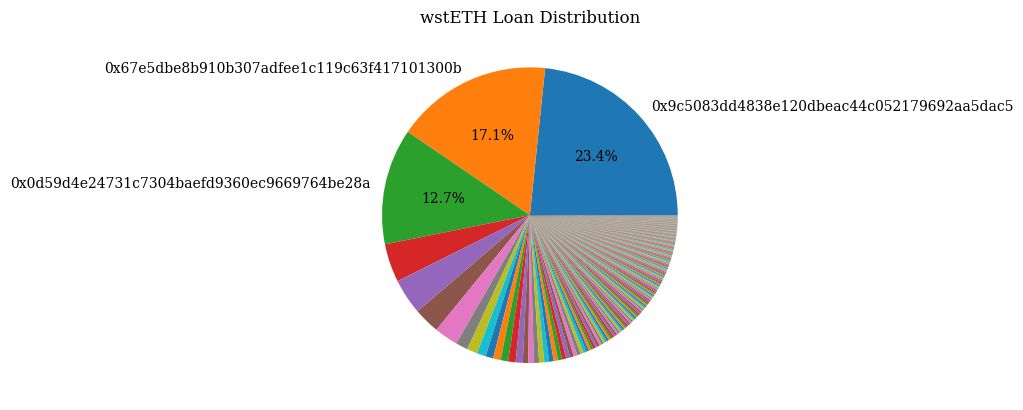

In [47]:
import matplotlib.pyplot as plt


def custom_autopct(pct):
    return "{:.1f}%".format(pct) if pct > 5 else ""


controller = scenario.controller
total_debt = 0
loans = {}
for user, loan in controller.loan.items():
    debt = loan.initial_debt / 1e18
    loans[user] = debt
    total_debt += debt

thresh = 0.05 * total_debt
loans = dict(sorted(loans.items(), key=lambda x: x[1], reverse=True))
labels = [a if loans[a] > thresh else "" for a in loans.keys()]
f, ax = plt.subplots()
pie = ax.pie(loans.values(), labels=labels, autopct=custom_autopct)
ax.set_title(f"{scenario.market_name} Loan Distribution")

### Run the Sim

In [48]:
# with cProfile.Profile() as pr:
for sample in scenario.pricepaths:
    scenario.prepare_for_trades(sample)  # update prices/timestamps
    scenario.perform_actions(sample)  # arbitrage, liquidate, update
    processor.update(sample.timestamp, inplace=True)  # collect metrics
# stats = pstats.Stats(pr)
# stats.sort_stats(pstats.SortKey.CUMULATIVE)
# stats.print_stats()

In [49]:
results = processor.process()

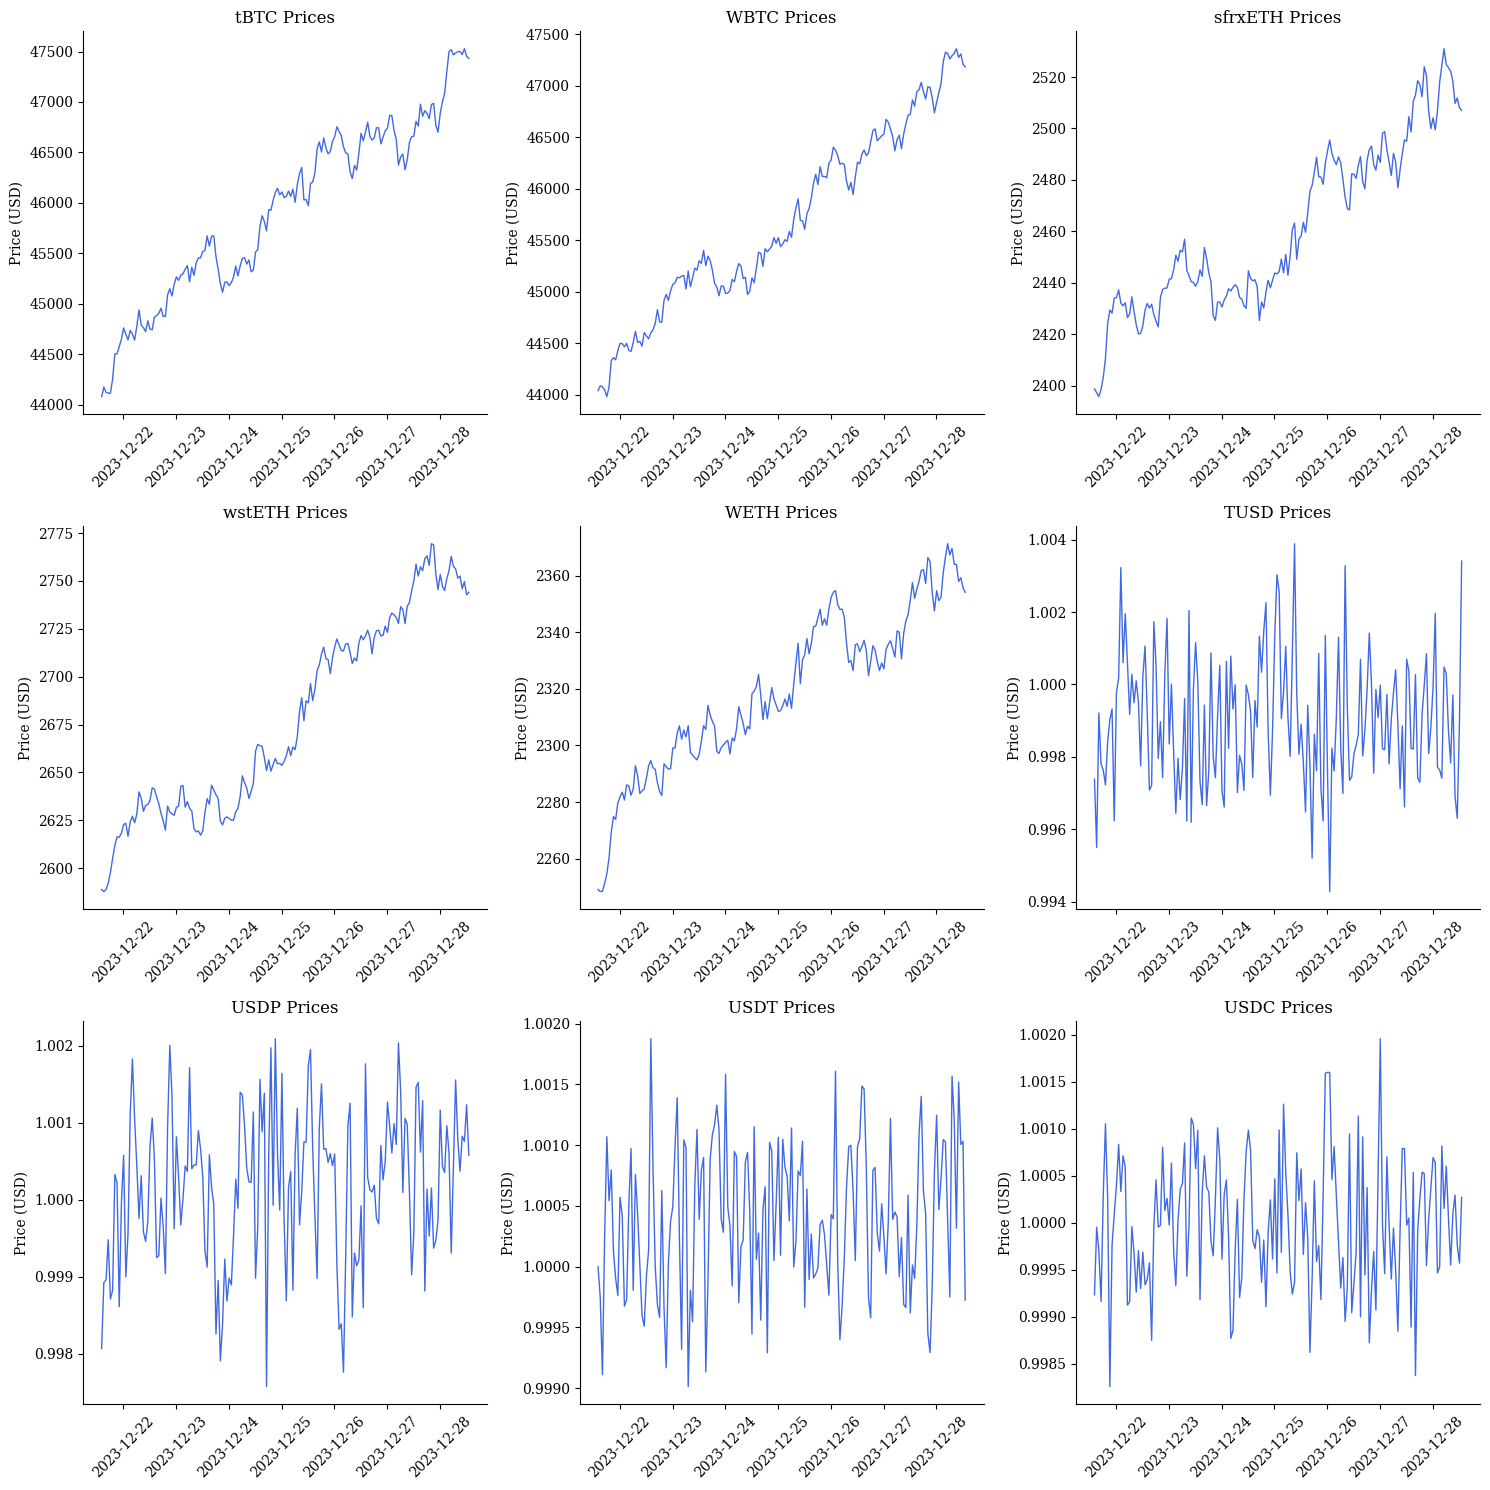

In [50]:
results.plot_prices()

In [51]:
df = results.df
df.to_csv("../data/results.csv")
df.tail()

,arbitrageur_profit,arbitrageur_volume,arbitrageur_count,liquidator_profit,liquidator_volume,liquidator_count,keeper_profit,keeper_volume,keeper_count,borrower_profit,borrower_volume,borrower_count,liquidityprovider_profit,liquidityprovider_volume,liquidityprovider_count,aggregator_price,controller_wstETH_system_health,controller_wstETH_bad_debt,controller_wstETH_num_loans,controller_wstETH_total_debt,controller_wstETH_users_to_liquidate,llamma_wstETH_price,llamma_wstETH_oracle_price,llamma_wstETH_fees_x,llamma_wstETH_fees_y,llamma_wstETH_bal_x,llamma_wstETH_bal_y,pk_crvUSD/TUSD_debt,pk_crvUSD/TUSD_profit,pk_crvUSD/USDP_debt,pk_crvUSD/USDP_profit,pk_crvUSD/USDC_debt,pk_crvUSD/USDC_profit,pk_crvUSD/USDT_debt,pk_crvUSD/USDT_profit,stablecoin_total_supply,stableswap_crvUSD_TUSD_price,stableswap_crvUSD_TUSD_ma_price,stableswap_crvUSD_TUSD_lp_supply,stableswap_crvUSD_TUSD_virtual_price,stableswap_crvUSD_TUSD_TUSD_bal,stableswap_crvUSD_TUSD_crvUSD_bal,stableswap_crvUSD_USDP_price,stableswap_crvUSD_USDP_ma_price,stableswap_crvUSD_USDP_lp_supply,stableswap_crvUSD_USDP_virtual_price,stableswap_crvUSD_USDP_USDP_bal,stableswap_crvUSD_USDP_crvUSD_bal,stableswap_crvUSD_USDC_price,stableswap_crvUSD_USDC_ma_price,stableswap_crvUSD_USDC_lp_supply,stableswap_crvUSD_USDC_virtual_price,stableswap_crvUSD_USDC_USDC_bal,stableswap_crvUSD_USDC_crvUSD_bal,stableswap_crvUSD_USDT_price,stableswap_crvUSD_USDT_ma_price,stableswap_crvUSD_USDT_lp_supply,stableswap_crvUSD_USDT_virtual_price,stableswap_crvUSD_USDT_USDT_bal,stableswap_crvUSD_USDT_crvUSD_bal
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-28 09:07:27,166715.381748,0,492,21699.163268,0,10,0.0,0,0,0.0,0,0,0.0,0,0,0.999252,0.719972,5.144827e+06,313,3.529448e+07,1,2749.541908,2752.539338,1659,0,365761.492937,23493.474042,73333.405378,0,0.0,0,0.0,0,0.0,0,4.539783e+08,1.000291,1.000434,4.477169e+06,1.000867,2.402080e+06,2.078994e+06,0.998917,0.998705,4.142005e+06,1.000383,1.572801e+06,2.571044e+06,0.999505,0.999509,3.554462e+07,1.000239,0.000016,1.991815e+07,0.998897,0.998891,2.735668e+07,1.000281,0.000010,1.702938e+07
2023-12-28 10:07:27,167469.288422,0,493,21699.163268,0,10,0.0,0,0,0.0,0,0,0.0,0,0,0.999181,0.715699,5.144827e+06,313,3.529511e+07,1,2729.655198,2745.905228,1659,0,365761.492937,23493.474042,73333.405378,0,0.0,0,0.0,0,0.0,0,4.546514e+08,1.002006,1.001981,4.477169e+06,1.000874,3.075982e+06,1.405822e+06,0.998917,0.998914,4.142005e+06,1.000383,1.572801e+06,2.571044e+06,0.999505,0.999505,3.554462e+07,1.000239,0.000016,1.991815e+07,0.998598,0.998602,2.735668e+07,1.000282,0.000010,1.770252e+07
2023-12-28 11:07:27,167489.928276,0,494,21699.163268,0,10,0.0,0,0,0.0,0,0,0.0,0,0,0.999175,0.718116,5.144827e+06,313,3.529574e+07,1,2740.966562,2749.734202,1659,0,365761.492937,23493.474042,73333.405378,0,0.0,0,0.0,0,0.0,0,4.547270e+08,1.002327,1.002322,4.477169e+06,1.000875,3.151684e+06,1.330288e+06,0.998702,0.998702,4.142005e+06,1.000384,1.497364e+06,2.646574e+06,0.999505,0.999505,3.554462e+07,1.000239,0.000016,1.991815e+07,0.998598,0.998598,2.735668e+07,1.000282,0.000010,1.770252e+07
2023-12-28 12:07:27,167777.349825,0,497,21699.163268,0,10,0.0,0,0,0.0,0,0,0.0,0,0,0.999206,0.713582,5.144827e+06,313,3.529638e+07,1,2724.998992,2742.694671,1755,0,381869.662643,23487.592765,73333.405378,0,0.0,0,0.0,0,0.0,0,4.552490e+08,1.000977,1.000998,4.477169e+06,1.000880,2.736462e+06,1.744876e+06,0.998702,0.998702,4.142005e+06,1.000384,1.497364e+06,2.646574e+06,0.999630,0.999605,3.554462e+07,1.000240,0.000016,1.939610e+07,0.998553,0.998553,2.735668e+07,1.000282,0.000010,1.779384e+07
2023-12-28 13:07:27,172591.546857,0,501,21699.163268,0,10,0.0,0,0,0.0,0,0,0.0,0,0,0.999230,0.714431,5.144827e+06,313,3.529701e+07,1,2729.001036,2744.070500,1755,0,381869.662643,23487.592765,73333.405378,0,0.0,0,0.0,0,0.0,0,4.579164e+08,0.996690,0.997612,4.477169e+06,1.000898,1.152381e+06,3.330187e+06,0.998776,0.998776,4.142005e+06,1.000384,1.522255e+06,2.621653e+06,0.999365,0.999368,3.554462e+07,1.000242,0.0

In [52]:
results.metric_map

{'AgentMetrics': 0,
 'AggregatorMetrics': 1,
 'ControllerMetrics': 2,
 'LLAMMAMetrics': 3,
 'PegKeeperMetrics': 4,
 'StablecoinMetrics': 5,
 'StableSwapMetrics': 6}

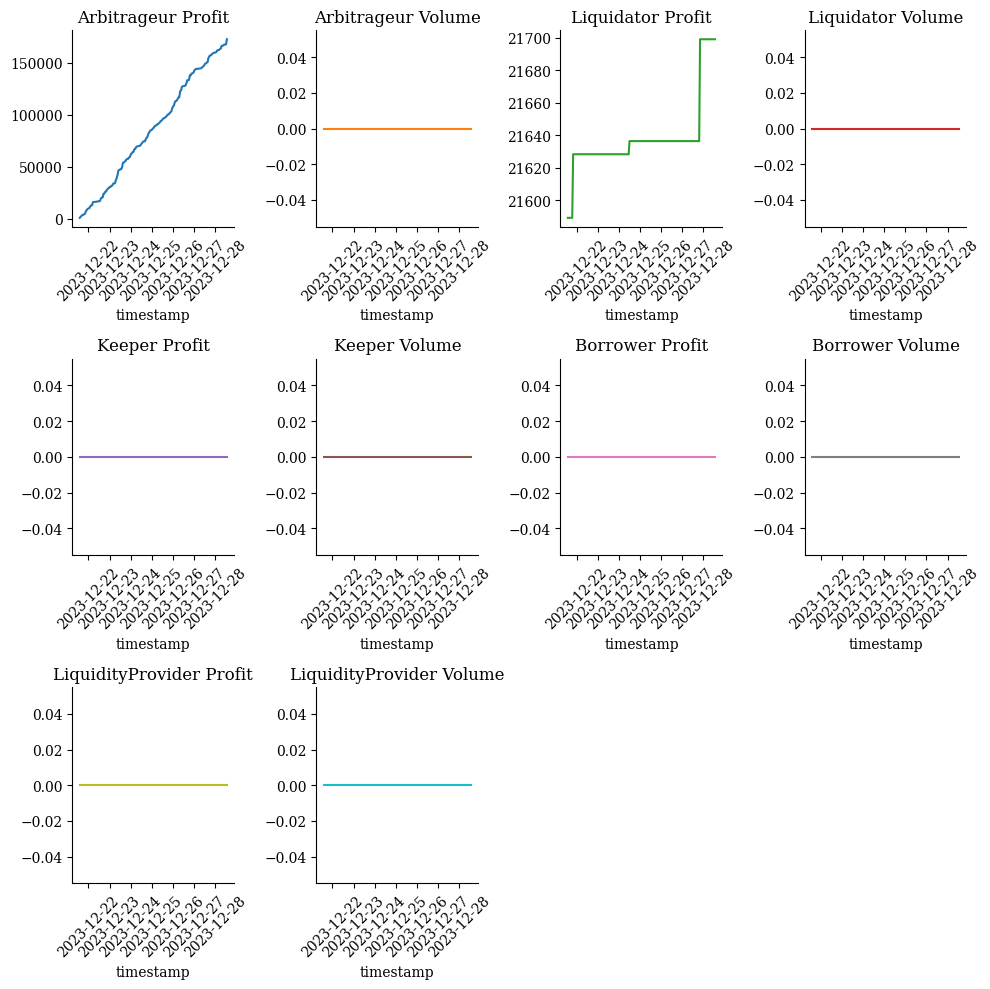

In [53]:
results.plot_metric(0, show=True)

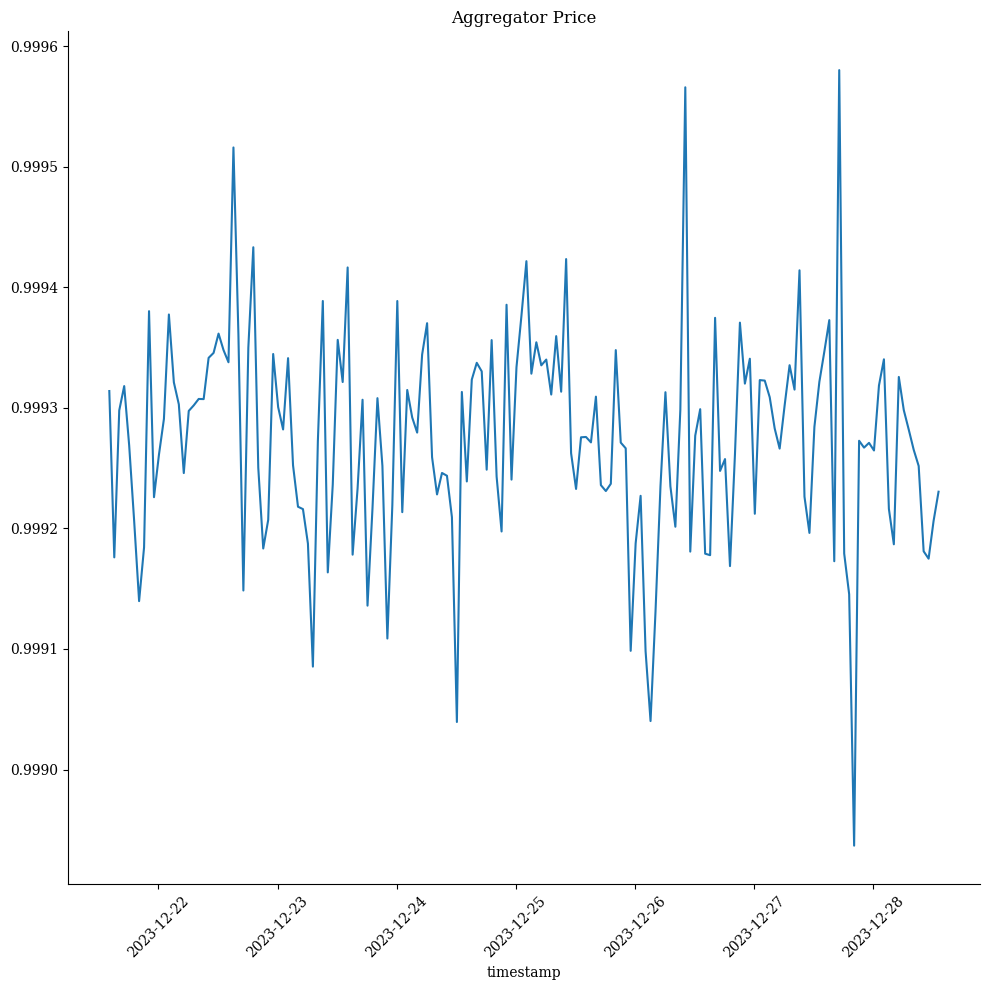

In [54]:
results.plot_metric(1, show=True)

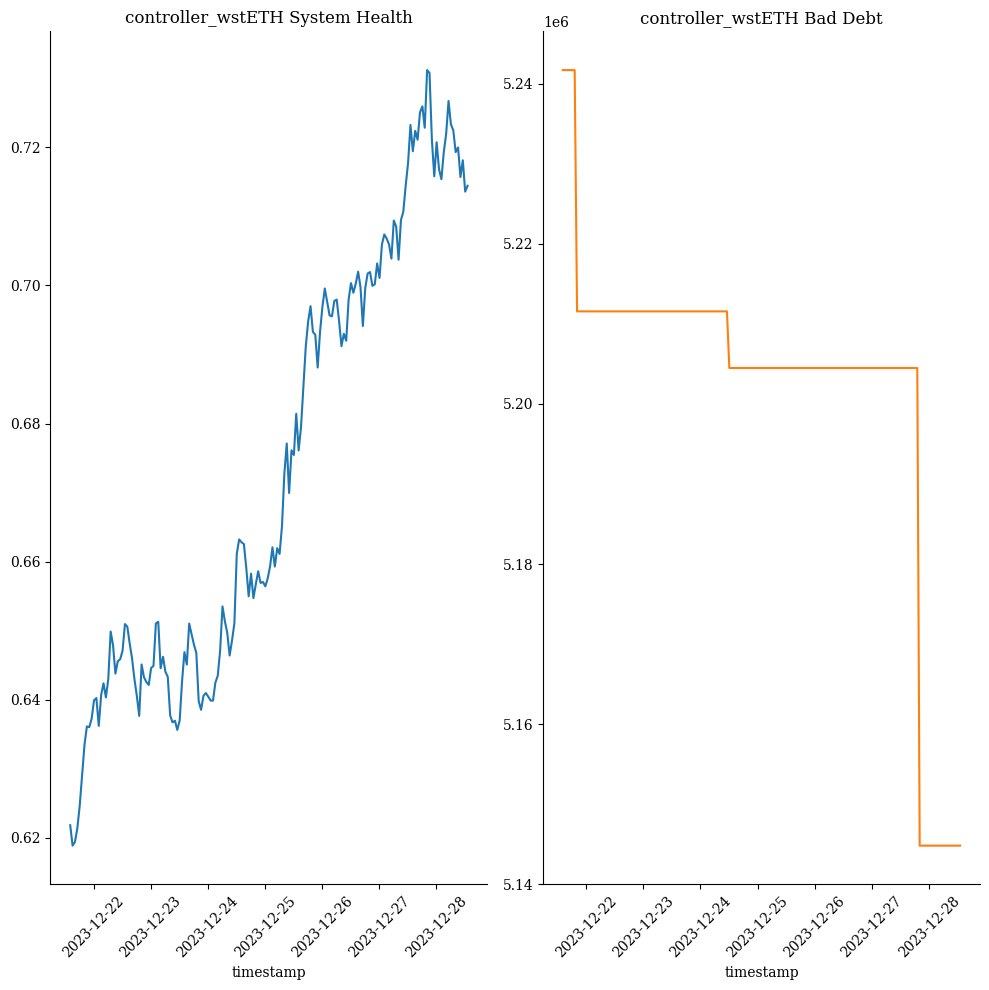

In [55]:
results.plot_metric(2, show=True)

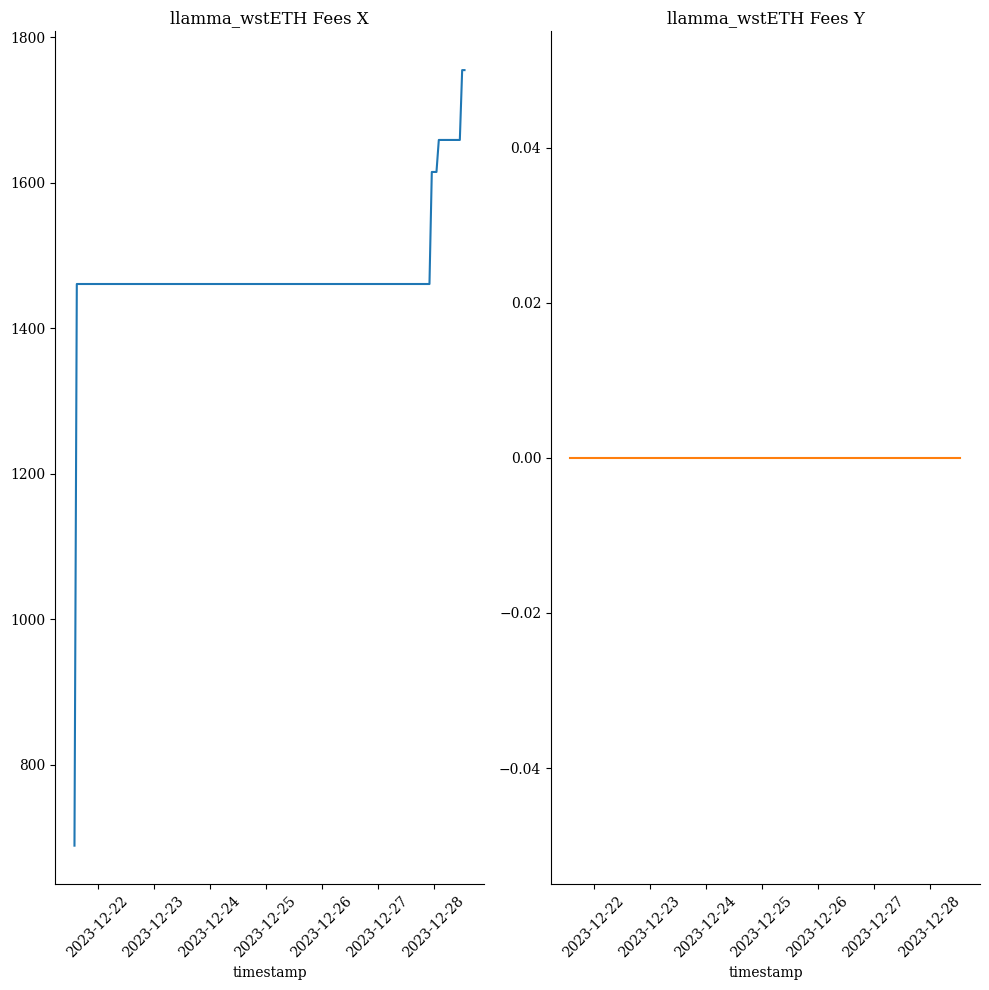

In [56]:
results.plot_metric(3, show=True)  # seems broken from crvusdsim

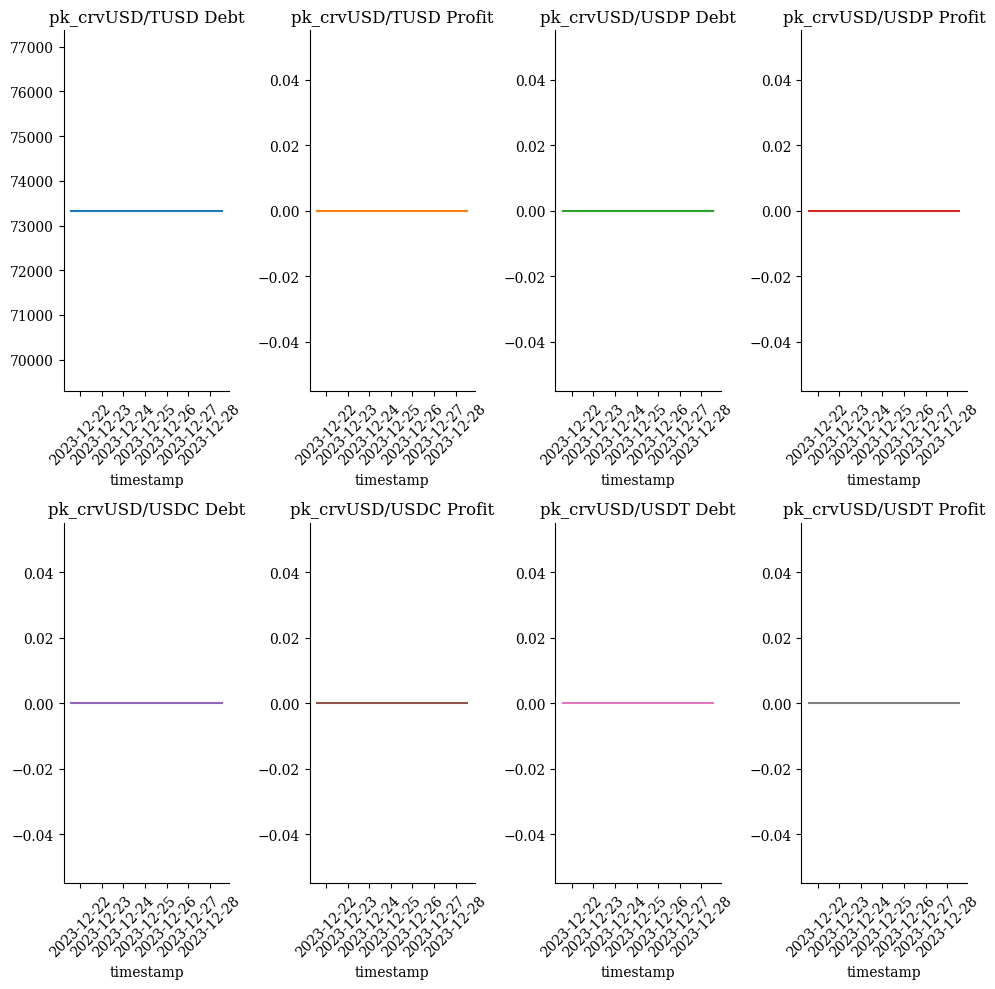

In [57]:
results.plot_metric(4, show=True)

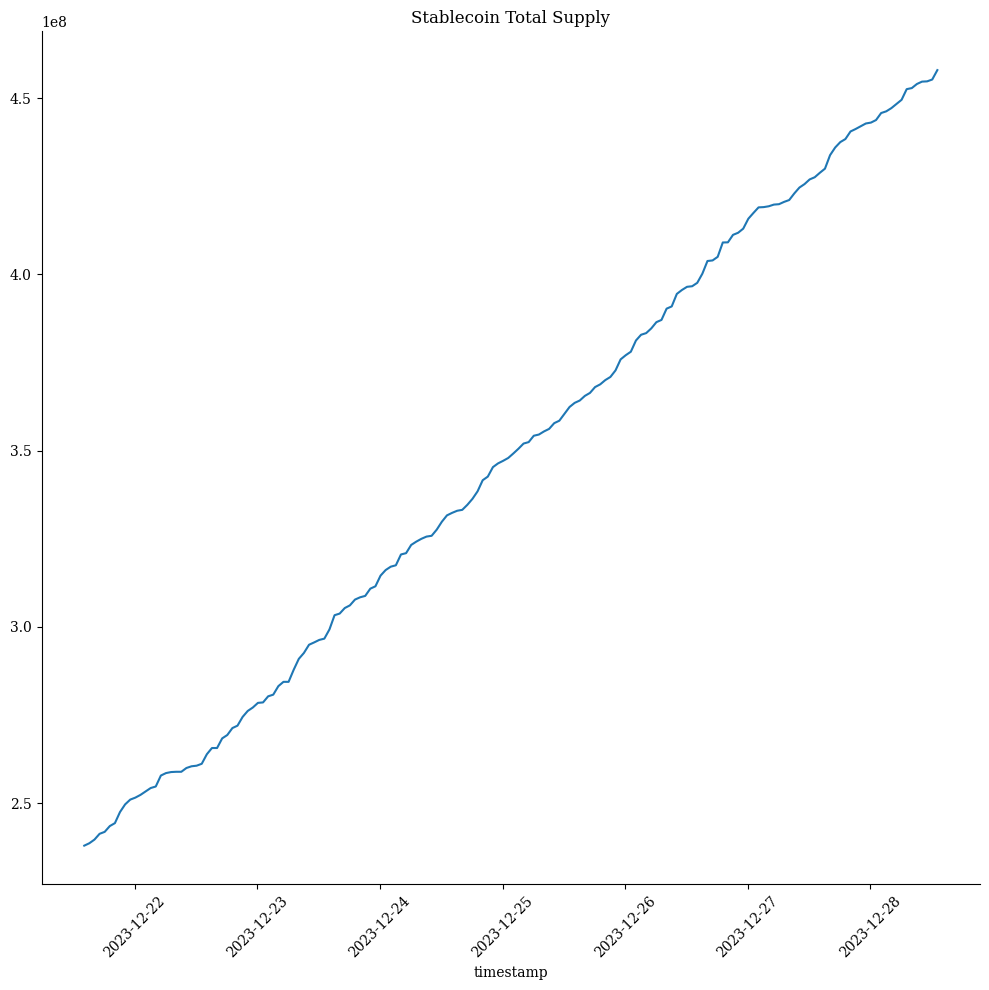

In [58]:
results.plot_metric(5, show=True)

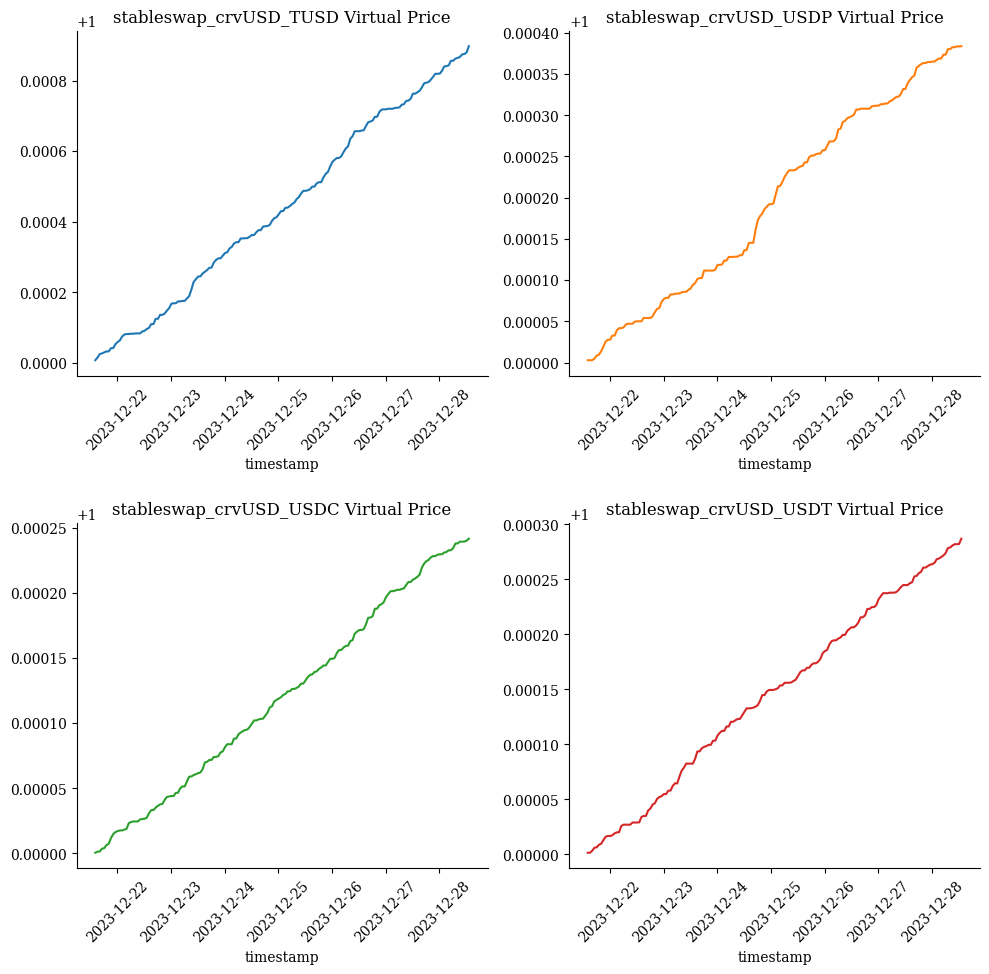

In [59]:
results.plot_metric(6, show=True)

In [123]:
summary = results.summarize().T
summary.columns = ["value"]
summary

,value
arbitrageur_profit_max,1.725915e+05
arbitrageur_volume_max,0.000000e+00
liquidator_profit_max,2.169916e+04
liquidator_volume_max,0.000000e+00
keeper_profit_max,0.000000e+00
keeper_volume_max,0.000000e+00
borrower_profit_max,0.000000e+00
borrower_volume_max,0.000000e+00
liquidityprovider_profit_max,0.000000e+00
liquidityprovider_volume_max,0.000000e+00
